In [25]:
import matplotlib.pyplot as plt
import os
import wave
import pylab
import tensorflow as tf
from pathlib import Path


# Set paths to input and output data
INPUT_DIR = 'C:/Users/hennm/Dropbox/Studium/Master/Semester 2/Tec Lab/Music/Samples/'
OUTPUT_DIR = 'C:/Users/hennm/Dropbox/Studium/Master/Semester 2/Tec Lab/Music/Output'

# Print names of 10 WAV files from the input path
parent_list = os.listdir(INPUT_DIR)
'''
for i in range(10):
    print(parent_list[i])
'''

Tea K Pea - nauticals_1.wav
Tea K Pea - nauticals_10.wav
Tea K Pea - nauticals_100.wav
Tea K Pea - nauticals_101.wav
Tea K Pea - nauticals_102.wav
Tea K Pea - nauticals_103.wav
Tea K Pea - nauticals_104.wav
Tea K Pea - nauticals_105.wav
Tea K Pea - nauticals_106.wav
Tea K Pea - nauticals_107.wav


In [33]:
# Utility function to get sound and frame rate info
def get_wav_info(wav_file):
    wav = wave.open(wav_file, 'r')
    frames = wav.readframes(-1)
    sound_info = pylab.frombuffer(frames, 'int16')
    frame_rate = wav.getframerate()
    wav.close()
    return sound_info, frame_rate

# For every recording, make a spectogram and save it as label_speaker_no.png
if not os.path.exists(os.path.join(OUTPUT_DIR, 'audio-images')):
    os.mkdir(os.path.join(OUTPUT_DIR, 'audio-images'))

for filename in os.listdir(INPUT_DIR):
    if "wav" in filename:
        file_path = os.path.join(INPUT_DIR, filename)
        file_stem = Path(file_path).stem
        target_dir = f'class_{file_stem[0]}'
        dist_dir = os.path.join(os.path.join(OUTPUT_DIR, 'audio-images'), target_dir)
        file_dist_path = os.path.join(dist_dir, file_stem)
        if not os.path.exists(file_dist_path + '.png'):
            if not os.path.exists(dist_dir):
                os.mkdir(dist_dir)
            file_stem = Path(file_path).stem
            sound_info, frame_rate = get_wav_info(file_path)
            pylab.specgram(sound_info, Fs=frame_rate)
            pylab.savefig(f'{file_dist_path}.png')
            pylab.close()

# Print the class in our dataset
path_list = os.listdir(os.path.join(OUTPUT_DIR, 'audio-images'))
print("Classes: \n")
print(path_list)

# File names for class
path_list = os.listdir(os.path.join(OUTPUT_DIR, 'audio-images/class_T'))
print("\nA few example files: \n")
for i in range(10):
    print(path_list[i])

Classes: 

['class_T']

A few example files: 

Tea K Pea - nauticals_1.png
Tea K Pea - nauticals_10.png
Tea K Pea - nauticals_100.png
Tea K Pea - nauticals_101.png
Tea K Pea - nauticals_102.png
Tea K Pea - nauticals_103.png
Tea K Pea - nauticals_104.png
Tea K Pea - nauticals_105.png
Tea K Pea - nauticals_106.png
Tea K Pea - nauticals_107.png


In [34]:
# Declare constants
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
BATCH_SIZE = 32
N_CHANNELS = 3
N_CLASSES = 10

# Make a dataset containing the training spectrograms
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             directory=os.path.join(OUTPUT_DIR, 'audio-images'),
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="training",
                                             seed=0)

# Make a dataset containing the validation spectrogram
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             directory=os.path.join(OUTPUT_DIR, 'audio-images'),
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="validation",
                                             seed=0)

Found 177 files belonging to 1 classes.
Using 142 files for training.
Found 177 files belonging to 1 classes.
Using 35 files for validation.


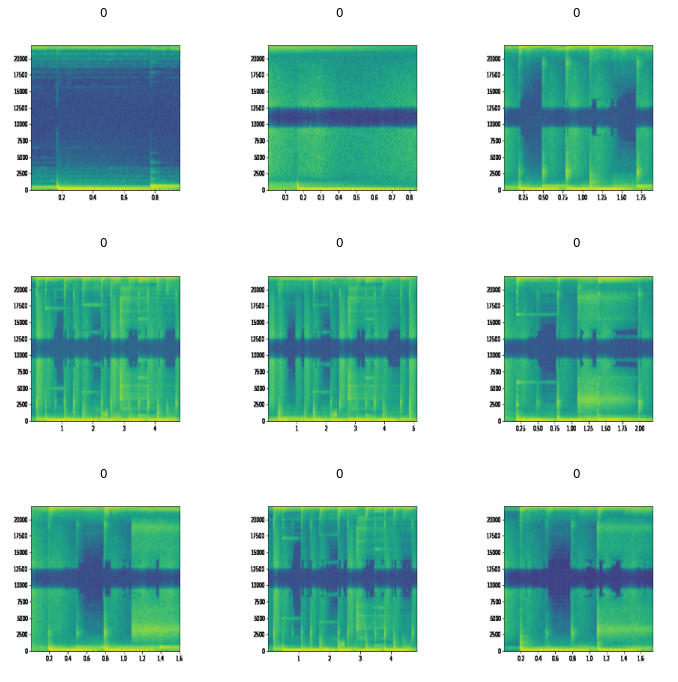

In [10]:
plt.figure(figsize=(12, 12))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.show()

In [11]:
# Function to prepare our datasets for modelling
def prepare(ds, augment=False):
    # Define our one transformation
    rescale = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1./255)])
    flip_and_rotate = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
    ])

    # Apply rescale to both datasets and augmentation only to training
    ds = ds.map(lambda x, y: (rescale(x, training=True), y))
    if augment: ds = ds.map(lambda x, y: (flip_and_rotate(x, training=True), y))
    return ds

train_dataset = prepare(train_dataset, augment=False)
valid_dataset = prepare(valid_dataset, augment=False)

In [23]:
# Create CNN model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))
model.add(tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(N_CLASSES, activation='softmax'))

# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(),
    metrics=['accuracy'],
)

# Train model for 10 epochs, capture the history
history = model.fit(train_dataset, epochs=3, validation_data=valid_dataset)

Epoch 1/3
5/5 [==============================] - 4s 570ms/step - loss: 2.5265 - accuracy: 0.5000 - val_loss: 0.7509 - val_accuracy: 1.0000
Epoch 2/3
5/5 [==============================] - 3s 531ms/step - loss: 2.0471 - accuracy: 0.9577 - val_loss: 0.6601 - val_accuracy: 1.0000
Epoch 3/3
5/5 [==============================] - 3s 547ms/step - loss: 1.8917 - accuracy: 1.0000 - val_loss: 0.5365 - val_accuracy: 1.0000


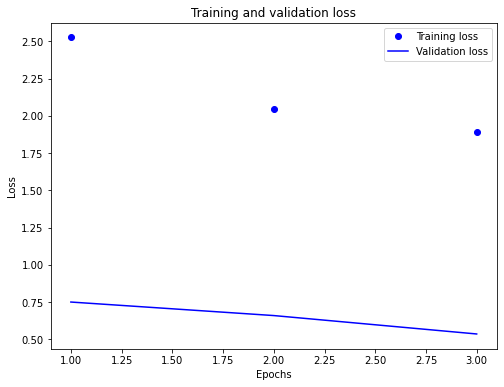

In [24]:
# Plot the loss curves for training and validation.
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

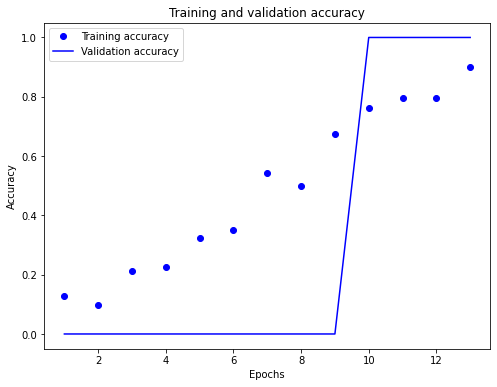

In [20]:
# Plot the accuracy curves for training and validation.
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [21]:
# Compute the final loss and accuracy
final_loss, final_acc = model.evaluate(valid_dataset, verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

Final loss: 0.264486, final accuracy: 1.000000


TypeError: Conv1D.__init__() missing 2 required positional arguments: 'filters' and 'kernel_size'

In [41]:
from keras import models, layers

model = models.Sequential()
model.add(layers.Conv2D(32, 44100, strides=(1, 1), padding="valid", activation='relu', input_shape=(44100, 2)))
model.add(layers.MaxPooling2D(22050))
model.add(layers.Conv2D(64, 44100, activation='relu'))
model.add(layers.MaxPooling2D(22050))
model.add(layers.Conv2D(64, 44100), activation='relu')


ValueError: Input 0 of layer "conv2d_16" is incompatible with the layer: expected min_ndim=4, found ndim=3. Full shape received: (None, 44100, 2)

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
Total params: 56,320
Trainable params: 56,320
Non-traina

In [19]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)              0

In [13]:
import tensorflow as tf
from keras import models, layers, Input
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()


n_steps_in = 9792000
n_output = 1
n_features = 1

dilation_rates = [1, 2, 4]
n_filters = 4
filter_width = 2

# Loading the song
test_file = tf.io.read_file('C:/Users/hennm/Dropbox/Studium/Master/Semester 2/Tec Lab/Music/WAV/Tea K Pea - '
                              'nauticals.wav')
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

test_audio_reshape = test_audio.reshape(-1, 1, 2)

input_seq = tf.keras.layers.Input(tensor=test_audio_reshape)
x = input_seq
skips = []
for dilation in dilation_rates:

  x = tf.keras.layers.Conv1D(filters = 16,
                             kernel_size = 1,
                             padding = 'same',
                             activation = 'relu')(x)

  x_d = tf.keras.layers.Conv1D(filters = n_filters,
                               kernel_size = filter_width,
                               padding = 'causal',
                               dilation_rate = dilation,
                               activation = tf.keras.activations.swish)(x)

  z = tf.keras.layers.Conv1D(filters = 16,
                             kernel_size = 1,
                             padding = 'same',
                             activation = 'relu')(x_d)

  x = tf.keras.layers.Add()([x, z])

  skips.append(z)

# assemble the skips
out = tf.keras.layers.Add()(skips)
out = tf.keras.layers.Conv1D(filters = 1,
                             kernel_size = 1,
                             padding = 'same')(out)
out = tf.keras.layers.Flatten()(out)
output = tf.keras.layers.Dense(n_output, activation = 'relu')(out)




AttributeError: 'KerasTensor' object has no attribute 'summary'

In [ ]:

'''
# Keras model
model = models.Sequential()
model.add(Input(tensor=test_audio))
model.add(layers.Conv1D(filters=2, kernel_size=2, activation='sigmoid', padding='valid', input_shape=(None, 2)))
'''